# Feature Selection with Lending Club Dataset

<!-- introduction - what is FS and why do we need to do it -->
One of the most relevant topics in machine learning is identifying which features or attributes to use in your models. In most real world problems, data often has many features but only few are related to the target we are interested in. Feature selection is the process of selecting a subset of features which are then used in model construction.

We are going to look at data from a popular lending marketplace Lending Club.  Lending club has been transforming the banking system with it's peer-to-peer lending model, where it acts as a bridge between the investor and the borrowers. In this end to end example we're going to be examining different attributes that lending club collects from borrowers and how they influence the interest rates. The dataset contains loan applications from 2007 through 2018 with current loan status and payment information.

Our example dataset has 150 columns containing both categorical and continuous attributes. With feature selection, we are going to create a model with as good or better accuracy while requiring lesser data. Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.

In [1]:
# general imports
import pandas as pd
import numpy as np
import itertools
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# models
from sklearn import ensemble
from sklearn.linear_model import Ridge, Lasso, LassoLars, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# metrics
from sklearn import metrics

# misc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, VarianceThreshold, RFE
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from multiprocessing import Pool
from sklearn import model_selection

## Cleaning and preparing dataset

Feature selection goes hand in hand with the initial steps of cleaning and preparing your data before the training process.


Checking for missing values is a good first step in preparing the data. We have chosen to remove columns where more than 65% of the values are empty. By working on the dataset slice-by-slice, we have converted the categorical features to one-hot encoding. Next, we will jump into various feature selection methods.

In [2]:
# reading the dataset
loan_df = pd.read_csv("loan.csv")

/var/folders/qb/clq6twsx7wz60w7pwrf8977h0000gn/T/ipykernel_37153/340379443.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv("loan.csv")


In [3]:
# looking at missing values
# percentage of null values in each of the columns 
missing_val = loan_df.isna().sum()/len(loan_df)*100
print("Columns with more than 60% missing values - ")
print(missing_val[missing_val > 60].sort_values(ascending=False))
# since we cannot fill in values for these columns we're going to drop these
loan_df = loan_df.loc[:, loan_df.isnull().mean() < .35]
print(loan_df.shape)
# got rid of ~50 cols with that threshold

Columns with more than 60% missing values - 
mo_sin_old_il_acct                100.000000
mo_sin_old_rev_tl_op              100.000000
mo_sin_rcnt_tl                    100.000000
mort_acc                          100.000000
mths_since_recent_bc              100.000000
mths_since_recent_bc_dlq          100.000000
mths_since_recent_inq             100.000000
mths_since_recent_revol_delinq    100.000000
num_accts_ever_120_pd             100.000000
num_actv_bc_tl                    100.000000
num_actv_rev_tl                   100.000000
num_bc_sats                       100.000000
num_bc_tl                         100.000000
num_il_tl                         100.000000
num_op_rev_tl                     100.000000
num_rev_accts                     100.000000
num_rev_tl_bal_gt_0               100.000000
num_sats                          100.000000
num_tl_120dpd_2m                  100.000000
num_tl_30dpd                      100.000000
num_tl_90g_dpd_24m                100.000000
num_tl_op_

In [5]:
# dropping arbitrary applicant input
loan_df.drop(columns = ['emp_title', 'title', 'initial_list_status'], axis = 1, inplace = True)

In [6]:
# looking at cols of object type - convert dates to duration, emp_length to int, encode grade and subgrade, 
loan_df.select_dtypes(include='object').columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

In [7]:
# all dates like issue_d, earliest_cr_line, last_credit_pull_d will be converted to duration
dttoday = datetime.now().strftime('%Y-%m-%d')
loan_df.fillna({'earliest_cr_line':dttoday, 'issue_d':dttoday, 'last_credit_pull_d':dttoday}, inplace=True)
loan_df[['earliest_cr_line', 'issue_d', 'last_credit_pull_d']] = loan_df[['earliest_cr_line', 'issue_d', 'last_credit_pull_d']].apply(pd.to_datetime)

loan_df['earliest_cr_line'] = loan_df['earliest_cr_line'].apply(lambda x: (np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)
loan_df['last_credit_pull_d'] = loan_df['last_credit_pull_d'].apply(lambda x: (np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)
loan_df['issue_d'] = loan_df['issue_d'].apply(lambda x: (np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

loan_df[['earliest_cr_line', 'issue_d', 'last_credit_pull_d']].head(5)

,earliest_cr_line,issue_d,last_credit_pull_d
0,18.284932,0.605479,0.435616
1,32.128767,0.605479,0.435616
2,8.279452,0.605479,0.435616
3,13.443836,0.605479,0.435616
4,18.616438,0.605479,0.435616


In [8]:
# convert zip from string to int
loan_df['zip_code'] = loan_df['zip_code'].apply(lambda x: str(x)[:3])
loan_df['zip_code'] = pd.to_numeric(loan_df['zip_code'], errors='coerce')
loan_df['zip_code'].fillna(0, inplace=True)

In [9]:
# converting emp_years to int
loan_df.fillna({'emp_length':'0 years', 'term':'Unknown', 'home_ownership':'Unknown',
                'verification_status':'Unknown', 'loan_status':'Unknown', 'purpose':'Unknown',
                'addr_state':'Unknown', 'application_type':'Unknown', 'disbursement_method':'Unknown'}, inplace=True)
loan_df['emp_length'].value_counts()

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
0 years      146907
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: emp_length, dtype: int64

In [10]:
# converting emp_length to float
dict_emp_length = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':0.5, '2 years':2,
       '9 years':9, '0 years':0, '5 years':5, '3 years':3, '7 years':7, '1 year':1,
       '8 years':8}
loan_df['emp_length'].replace(dict_emp_length, inplace=True)

In [11]:
# dropping arbitrary applicant input, post loan attributes
to_drop = ['pymnt_plan', 'total_pymnt',
           'total_pymnt_inv','last_pymnt_d', 'last_pymnt_amnt', 'out_prncp',
           'out_prncp_inv', 'total_rec_prncp', 'hardship_flag', 'collection_recovery_fee',
           'collections_12_mths_ex_med', 'debt_settlement_flag','policy_code', 'grade', 'sub_grade']
loan_df.fillna(0, inplace=True)

In [12]:
loan_dummy_df = pd.get_dummies(loan_df.drop(columns=to_drop, axis=1))
loan_dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 150 entries, loan_amnt to disbursement_method_DirectPay
dtypes: float64(58), int64(3), uint8(89)
memory usage: 1.2 GB


In [13]:
# save new dataset for checkpointing
# loan_dummy_df.to_csv("loan_dummy.csv", index=False)
print(loan_dummy_df.shape)

# splitting into test and train after treating variables
X_train, X_test, y_train, y_test = train_test_split(loan_dummy_df, loan_df['int_rate'], 
                                                    test_size=0.3, random_state=42)

(2260668, 150)


In [14]:
X_train.drop(columns=['int_rate'], axis=1, inplace=True)
X_test.drop(columns=['int_rate'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
# number of columns in the cleaned dataset
print(X_train.shape[1])

149


### Keeping track of models

With a large number of variables, hyperparameters and different types of models, it is easy to lose track of the progress we have made. To help with this problem we are going to be using the [Verta.AI](https://www.verta.ai/)'s model management platform to keep track of models and graphs that we build thoughout the process. Setting up Verta is simple and straightforward and more information can be found [here](https://verta.readme.io/docs/getting-started).

In [16]:
# app settings
from verta import Client

# setting up
HOST = "app.verta.ai"
EMAIL = "your-email@gmail.com"
DEV_KEY= "your-dev-key"
PROJECT_NAME = "Feature-Selection"

client = Client(host=HOST,
                email=EMAIL, 
                dev_key=DEV_KEY,
                ignore_conn_err=True)
proj = client.set_project(PROJECT_NAME)

connection successfully established
created new Project: 


## Getting out hands dirty

Now that our cleaned datset is in place and we have our model logging set up, we will look at 5 popular methods across these categories in detail:

1. Using domain knowledge
2. Removing highly correlated features
3. Univariate feature selection
4. Recursive feature elimination
5. Embedded methods

For each method, we are going to use our smaller feature set which is created to train 3 different types of models -
1. elastic net model (baseline)
2. random forests
3. gradient boosting regressor

We have chosen these models as they generally work for large datasets, prevent overfitting and are straightforward to understand. However of the three models, the gradient boosting regressor takes the longest to train and requires hyperparameter tuning to be done for each feature set. If compute power is a constraint, skipping this model might be in your interest. 

**For each feature selection method, the modeling cells have been commented out to reduce the runtime of this kernel, to run any model, feel free to uncomment those lines**

### Models + Logging

In [17]:
# Calculating and logging mean absolute error and root mean squared error for each model
def get_metrics(X_train, y_train, X_test, y_test, model, run=None):
    
    print("Getting metrics for model")
    # train prediction
    train_preds = model.predict(X_train)
    # test prediction
    test_preds = model.predict(X_test)

    # Calculate the absolute errors
    train_errors = abs(train_preds - y_train)
    test_errors = abs(test_preds - y_test)
    
    # mean absolute error (mae)
    train_mae = round(np.mean(train_errors), 4)
    test_mae = round(np.mean(test_errors), 4)
    print("train mae: ", train_mae, " test mae: ", test_mae)

    # root mean sq error
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, test_preds))
    print("train rmse: ", train_mae, " test rmse: ", test_mae)

    
    # log values only if run is provided    
    if run:
        run.log_metric("train_mae", train_mae)
        run.log_metric("train_rmse", train_rmse)
        run.log_metric("test_mae", test_mae)
        run.log_metric("test_rmse", test_rmse)
    
    return train_mae, test_mae, train_rmse, test_rmse

In [18]:
# Elastic net model - this logs all hyperparameters, features and metrics
def elastic_net_model(tags, feature_set, drop = True,  **params):
    # elastic net regression
    
    if drop:
        X_train_new = X_train.drop(columns = feature_set, axis = 1)
        X_test_new = X_test.drop(columns = feature_set, axis = 1)
    else:
        X_train_new = X_train.drop(X_train.columns.difference(feature_set), axis = 1)
        X_test_new = X_test.drop(X_train.columns.difference(feature_set), axis = 1)
    
    # grid search
    param_grid = {'l1_ratio': [.1, .5, .7, .85, .98, 1]} 
    en_regr = GridSearchCV(ElasticNet(), param_grid, 
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1, refit=True, cv=3, verbose=20, return_train_score=True)
    
    en_regr.fit(X_train_new, y_train)
    results = pd.DataFrame(en_regr.cv_results_)
    results[['mean_test_score', 'mean_train_score']] = results[['mean_test_score', 'mean_train_score']].apply(lambda x: np.abs(x))

    for _, run_result in results.iterrows():
        run = client.set_experiment_run()
        run.log_tags(tags)
        
        if drop:
            run.log_attribute("removed_features", removed_features)
        else:
            run.log_attribute("feature_set", feature_set)

        # log hyperparameters
        run.log_hyperparameters(run_result['params'])
        
        # run statistics    
        run.log_metric("mean_fit_time", run_result['mean_fit_time'])
        run.log_metric("std_fit_time", run_result['std_fit_time'])
        run.log_metric("mean_score_time", run_result['mean_score_time'])

        # log summary stats of validation
        run.log_metric("mean_train_score", run_result['mean_train_score'])
        run.log_metric("std_train_score", run_result['std_train_score'])  
    
        run.log_metric("mean_test_score", run_result['mean_test_score'])
        run.log_metric("std_test_score", run_result['std_test_score']) 
  

    # log best model
    run_baseline_en = client.set_experiment_run()
    run_baseline_en.log_hyperparameters(en_regr.best_params_)
    run_baseline_en.log_model(key="elastic_net_model", model=en_regr)
    run_baseline_en.log_tags(tags+['best model'])
    
    train_mae, test_mae, train_rmse, test_rmse = get_metrics(X_train = X_train_new,
                                                             y_train = y_train,
                                                             X_test = X_test_new,
                                                             y_test = y_test,
                                                             model = en_regr,
                                                             run = run_baseline_en)
    return en_regr

In [19]:
# Random forest model - this logs all hyperparameters, features and metrics
def random_forest_model(tags, feature_set, drop = True, **params):
    # Random Forest
    # creating new train and test sets
    # logging features     
    if drop:
        X_train_new = X_train.drop(columns = feature_set, axis = 1)
        X_test_new = X_test.drop(columns = feature_set, axis = 1)
    else:
        X_train_new = X_train.drop(X_train.columns.difference(feature_set), axis = 1)
        X_test_new = X_test.drop(X_train.columns.difference(feature_set), axis = 1)
    
    param_grid = {
    'n_estimators':[50],
    'max_depth': [4, 9],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    }
    
    rf = GridSearchCV(RandomForestRegressor(random_state=42),
                      param_grid, n_jobs=4, refit=True, verbose=20, cv=3, 
                      scoring='neg_mean_absolute_error',
                      return_train_score=True)
    
    rf.fit(X_train_new, y_train)
    
    results = pd.DataFrame(rf.cv_results_)
    results[['mean_test_score', 'mean_train_score']] = results[['mean_test_score', 'mean_train_score']].apply(lambda x: np.abs(x))

    for _, run_result in results.iterrows():
        run = client.set_experiment_run()
        run.log_tags(tags)
        
        if drop:
            run.log_attribute("removed_features", feature_set)
        else:
            run.log_attribute("feature_set", feature_set)

        # log hyperparameters
        run.log_hyperparameters(run_result['params'])
        
        run.log_metric("mean_fit_time", run_result['mean_fit_time'])
        run.log_metric("std_fit_time", run_result['std_fit_time'])
        run.log_metric("mean_score_time", run_result['mean_score_time'])

        # log summary stats of validation
        run.log_metric("mean_train_score", run_result['mean_train_score'])
        run.log_metric("std_train_score", run_result['std_train_score'])  
    
        run.log_metric("mean_test_score", run_result['mean_test_score'])
        run.log_metric("std_test_score", run_result['std_test_score']) 

    # best model
    run_rf = client.set_experiment_run()
    run_rf.log_hyperparameters(rf.best_params_)
    run_rf.log_model(key="model", model=rf)
    run_rf.log_tags(tags+['best model'])

    # metrics for models
    train_mae, test_mae, train_rmse, test_rmse = get_metrics(X_train = X_train_new,
                                                             y_train = y_train,
                                                             X_test = X_test_new,
                                                             y_test = y_test,
                                                             model = rf,
                                                             run = run_rf)
    return rf

In [20]:
# GBR model - this logs all hyperparameters, features and metrics
def gbr_model(tags, feature_set, drop = True, **params):
    # Gradient Boosting Regressor
    # creating new train and test sets
    if drop:
        X_train_new = X_train.drop(columns = feature_set, axis = 1)
        X_test_new = X_test.drop(columns = feature_set, axis = 1)
    else:
        X_train_new = X_train.drop(X_train.columns.difference(feature_set), axis = 1)
        X_test_new = X_test.drop(X_train.columns.difference(feature_set), axis = 1)

    param_grid = {
        'n_estimators':[250],
        'learning_rate': [0.1, 0.01,0.05, 0.02],
        'max_depth': [4, 6, 9],
        'min_samples_leaf': [3, 7, 15]
             }

    gbr = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, verbose=20, refit=True,
                       cv=3, scoring='neg_mean_absolute_error',
                       return_train_score=True)
    
    gbr.fit(X_train_new, y_train)
    
    results = pd.DataFrame(gbr.cv_results_)
    results[['mean_test_score', 'mean_train_score']] = results[['mean_test_score', 'mean_train_score']].apply(lambda x: np.abs(x))

    for _, run_result in results.iterrows():
        run = client.set_experiment_run()
        run.log_tags(tags)
        
        if drop:
            run.log_attribute("removed_features", feature_set)
        else:
            run.log_attribute("feature_set", feature_set)

        # log hyperparameters
        run.log_hyperparameters(run_result['params'])
        
        run.log_metric("mean_fit_time", run_result['mean_fit_time'])
        run.log_metric("std_fit_time", run_result['std_fit_time'])
        run.log_metric("mean_score_time", run_result['mean_score_time'])

        # log summary stats of validation
        run.log_metric("mean_train_score", run_result['mean_train_score'])
        run.log_metric("std_train_score", run_result['std_train_score'])  
    
        run.log_metric("mean_test_score", run_result['mean_test_score'])
        run.log_metric("std_test_score", run_result['std_test_score']) 


    # log best model
    run_gbr = client.set_experiment_run()
    run_gbr.log_hyperparameters(gbr.best_params_)
    run_gbr.log_model(key="model", model=gbr)
    run_gbr.log_tags(tags+['best model'])

    # metrics for models
    train_mae, test_mae, train_rmse, test_rmse = get_metrics(X_train = X_train_new,
                                                             y_train = y_train,
                                                             X_test = X_test_new,
                                                             y_test = y_test,
                                                             model = gbr,
                                                             run = run_gbr)
    return gbr

### Using domain knowledge to remove features
Getting to know the dataset and how features can be used for the problem can give one a headstart on building a good model. In our case, the dataset comes with a data dictionary which is a good place to start. We are getting rid of columns which are free text provided by the borrower and columns related to incidents after the loan was granted as these are not of use to us.
Since we have already removed those columns in the cleaning stage, we can create a model with all the features to see how much worse the model would be.

In [21]:
# run_dk = client.set_experiment_run()
# loan_dummy_dk = pd.get_dummies(loan_df.drop(columns=['grade', 'sub_grade'], axis=1))


# # splitting into test and train after treating variables
# X_train_dk, X_test_dk, y_train_dk, y_test_dk = train_test_split(loan_dummy_dk, loan_dummy_dk['int_rate'], 
#                                                     test_size=0.3, random_state=42)

# # creating new train and test sets
# X_train_dk.drop(columns=['int_rate'], axis=1, inplace=True)
# X_test_dk.drop(columns=['int_rate'], axis=1, inplace=True)
# # MODEL:
# expt = client.set_experiment("domain_knowledge")

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_dk, y_train)
# # best model
# run_rf = client.set_experiment_run()
# run_rf.log_model(key="model", model=rf)
# run_rf.log_tags(['domain_knowledge', 'random_forest', 'no_HPP'])

# # metrics for models
# train_mae, test_mae, train_rmse, test_rmse = get_metrics(X_train = X_train_new,
#                                                          y_train = y_train,
#                                                          X_test = X_test_new,
#                                                          y_test = y_test,
#                                                          model = rf,
#                                                          run = run_rf)

### Removing low variance features

In sklearn’s `feature_selection` module we find `VarianceThreshold`. It removes all features whose variance doesn’t meet some threshold. By default it removes features with zero variance or features that have the same value for all samples.

In [22]:
expt_lv = client.set_experiment("low_variance")

# get list of all the original df columns
all_columns = X_train.columns

# instantiate VarianceThreshold object
vt = VarianceThreshold(threshold=0.2)

# fit vt to data
vt.fit(X_train)

# get the indices of the features that are being kept
feature_indices = vt.get_support(indices=True)

# remove low-variance columns from index
feature_names = [all_columns[idx]
                 for idx, _
                 in enumerate(all_columns)
                 if idx
                 in feature_indices]

# get the columns to be removed
removed_features = list(np.setdiff1d(all_columns,
                                     feature_names))
print("Found {0} low-variance columns."
      .format(len(removed_features)))
print("Low-variance columns", removed_features)

created new Experiment: 
Found 85 low-variance columns.
Low-variance columns ['acc_now_delinq', 'addr_state_AK', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI', 'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_MT', 'addr_state_NC', 'addr_state_ND', 'addr_state_NE', 'addr_state_NH', 'addr_state_NJ', 'addr_state_NM', 'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OK', 'addr_state_OR', 'addr_state_PA', 'addr_state_RI', 'addr_state_SC', 'addr_state_SD', 'addr_state_TN', 'addr_state_TX', 'addr_state_UT', 'addr_state_VA', 'addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY', 'application_type_Individual', 'appli

In [23]:
# # MODEL:
# # elatic net regr
# elastic_net_model(tags=["elastic net", "baseline"], feature_set=removed_features, drop=True)

In [24]:
# # MODEL:
# # random forest
# rf_lv = random_forest_model(tags=['random forest'], feature_set=removed_features, drop=True)

In [25]:
# # MODEL:
# # GBR
# gbr_lv = gbr_model(tags=['gradient boosting regressor'], feature_set=removed_features, drop=True)

### Removing highly correlated features
After examining our dataframe's correlation matrix we drop highly correlated/redundant data to address multicollinearity. When these are not removed it can lead to decreased generalization performance on the test set due to high variance and less model interpretability.

In [26]:
expt = client.set_experiment("Correlated features")

# corr matrix
cor = X_train.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor_stack = cor.stack()
print("Columns with corr. greater than 0.7 - ")
print(cor_stack[(cor_stack > 0.70) | (cor_stack < -0.70)])

created new Experiment: 
Columns with corr. greater than 0.7 - 
funded_amnt                    loan_amnt                      0.999759
funded_amnt_inv                loan_amnt                      0.999033
                               funded_amnt                    0.999332
installment                    loan_amnt                      0.945696
                               funded_amnt                    0.946034
                               funded_amnt_inv                0.945176
total_acc                      open_acc                       0.718098
total_rev_hi_lim               revol_bal                      0.787114
avg_cur_bal                    tot_cur_bal                    0.830753
bc_util                        revol_util                     0.799941
mo_sin_old_rev_tl_op           earliest_cr_line               0.827485
num_actv_rev_tl                num_actv_bc_tl                 0.834312
num_bc_sats                    num_actv_bc_tl                 0.841922
num_bc_tl    

In [27]:
# all cols whose corr is greater then 0.7; generated dummy columns excluded
cols_to_drop = ['funded_amnt', 'funded_amnt_inv', 'installment', 'total_acc', 'total_rev_hi_lim','avg_cur_bal',
                'bc_util', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'num_actv_rev_tl', 'num_bc_sats', 
                'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0',
                'num_sats','num_tl_30dpd', 'num_tl_op_past_12m', 'percent_bc_gt_75',
               'tax_liens', 'tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit']

In [28]:
# looking at columns highly correlated with the target column
int_rate_cor = X_train.apply(lambda x: x.corr(y_train))
print("Columns corr. to target variable -")
int_rate_cor[(int_rate_cor > 0.5) | (int_rate_cor < -0.5)]

Columns corr. to target variable -


Series([], dtype: float64)

In [29]:
# # MODEL:
# # elatic net regr
# elastic_net_model(tags=["elastic net", "baseline"], feature_set=cols_to_drop, drop=True)

In [30]:
# # MODEL:
# # random forest
# rf_corr = random_forest_model(tags=['random forest'], feature_set=cols_to_drop, drop=True)

In [31]:
# # MODEL:
# # GBR
# gbr_model(tags=['gradient boosting regressor'], feature_set=cols_to_drop, drop=True)

### Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. We can use sklearn’s `SelectKBest` to select a number of features to keep. This method uses statistical tests to select features having the highest correlation to the target.

In [32]:
expt = client.set_experiment("f_regr")

# for regression use f_regression
# k is the number of features selected, here it is set to 20 but can be varied
selector_f_reg = SelectKBest(f_regression, k=20).fit(X_train, y_train)

selected_cols = [d for d, s in zip(list(X_train.columns), selector_f_reg.get_support()) if s]
print("K best columns: ", selected_cols)

created new Experiment: 
K best columns:  ['installment', 'dti', 'inq_last_6mths', 'revol_util', 'total_rec_int', 'recoveries', 'total_rev_hi_lim', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'total_bc_limit', 'term_ 36 months', 'term_ 60 months', 'verification_status_Not Verified', 'verification_status_Verified', 'loan_status_Charged Off', 'purpose_credit_card', 'disbursement_method_DirectPay']


In [33]:
# # MODEL:
# # random forest
# random_forest_model(tags=['random forest', 'k=20'], feature_set=selected_cols, drop=False)

# # elatic net regr
# elastic_net_model(tags=["elastic net", "baseline"], feature_set=selected_cols, drop=False)

# # GBR
# gbr_model(tags=['gradient boosting regressor'], feature_set=selected_cols, drop=False)

### Recursive Feature Elimination
Recursive feature selection works by eliminating the least important features. It continues recursively until the specified number of features is reached. Recursive elimination can be used with any model that assigns weights to features, either through `coef_` or `feature_importances_`. Here we will use random forests to select the best features.

In [34]:
# RFE - Feature ranking with recursive feature elimination.
expt = client.set_experiment("RFE")

# run
run_rfe = client.set_experiment_run()

# n_features_to_select can be increased or decreased, 80 here is just an example
hyperparam_rfe = {"step":10, "n_features_to_select":80}
hyperparam_rfr = {"n_estimators":20, "max_depth":4}

estimator = RandomForestRegressor(random_state = 42, n_jobs=-1, **hyperparam_rfr)
selector = RFE(estimator, **hyperparam_rfe)

selector.fit(X_train, y_train)

print("Support: ", selector.support_)
run_rfe.log_artifact("support", selector.support_)
print("Ranking: ", selector.ranking_)
run_rfe.log_artifact("ranking", selector.ranking_)
selected_cols = [d for d, s in zip(list(X_train.columns), selector.support_) if s]
print("Selected Features: ", selected_cols)
run_rfe.log_artifact("feature_set", selected_cols)

run_rfe.log_hyperparameters(hyperparam_rfe)
run_rfe.log_hyperparameters(hyperparam_rfr)

run_rfe.log_tags(['random forest'])

train_mae, test_mae, train_rmse, test_rmse = get_metrics(X_train = X_train,
                                                         y_train = y_train,
                                                         X_test = X_test,
                                                         y_test = y_test,
                                                         model = selector,
                                                         run = run_rfe)

created new Experiment: 
created new ExperimentRun: 
Support:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True False  True  True  True  True False  True  True  True False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Ranking:  [1 1 1 1 1 1 1 1 1 

### Embedded methods 


Embedded methods combine the feature selection and the learning algorithm. A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification simultaneously.

#### Ridge
Ridge is another way to do feature selection, where we penalize the coefficients of the model for being too large. This is done by adding a penalty or shrinkage estimator to the regression, which can be controlled with the term *lambda*. Higher the value of lambda, more the shrinkage.

In [35]:
expt = client.set_experiment("ridge")
# Ridge
# increase the num in np.logspace() to search over a larger set of alpha values
hyperparam_candidates = {
    'alpha' : np.logspace(-4, -1, 1)
}
hyperparam_sets = [dict(zip(hyperparam_candidates.keys(), values))
                   for values
                   in itertools.product(*hyperparam_candidates.values())]

def run_experiment(hyperparams, **params):
    
    # create object to track experiment run
    run = client.set_experiment_run()
    run.log_tags(['ridge', 'regularization'])
    
    # log hyperparameters
    run.log_hyperparameters(hyperparams)
    print(hyperparams)
    
    # create and train model
    ridge_model = Ridge(**hyperparams)
    ridge_model.fit(X_train, y_train)
    
    train_mae, test_mae, train_rmse, test_rmse = get_metrics(X_train, y_train, X_test, y_test, ridge_model, run)
    print("train_mae, test_mae, train_rmse, test_rmse - ", train_mae, test_mae, train_rmse, test_rmse)
    
with Pool() as pool:
    pool.map(run_experiment, hyperparam_sets)

created new Experiment: 
created new ExperimentRun: 
{'alpha': 0.0001}


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.25277e-22): result may not be accurate.
  overwrite_a=True).T


Getting metrics for model
train mae:  2.1616  test mae:  2.1636
train rmse:  2.1616  test rmse:  2.1636
train_mae, test_mae, train_rmse, test_rmse -  2.1616 2.1636 2.812357521884802 2.8142122626638364


#### Lasso
Lasso Regression can be used to penalize the beta coefficients in a model, and it is very similar to ridge regression. It also adds a penalty term to the cost function of a model, with a *lambda* value that must be tuned. The most important distinction from ridge regression is that Lasso regression can force the Beta coefficient to zero, which will remove that feature from the model. This is why Lasso is preferred at times, especially when you are looking to reduce model complexity. The smaller number of features a model has, the lower the complexity.

In [36]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_x_train = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
print(scaled_x_train.shape == X_train.shape)
scaled_x_test = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)
print(scaled_x_test.shape == X_test.shape)

True
True


In [37]:
expt = client.set_experiment("Lasso")
# Lasso
# increase the num in np.logspace() to search over a larger set of alpha values
hyperparam_candidates = {
    'alpha' : np.logspace(-4, -1, 1)
}

hyperparam_sets = [dict(zip(hyperparam_candidates.keys(), values))
                   for values
                   in itertools.product(*hyperparam_candidates.values())]

def run_experiment(hyperparams):
    
    # create object to track experiment run
    run = client.set_experiment_run()
    run.log_tags(['lasso', 'regularization', 'scaled'])
    
    # log hyperparameters
    run.log_hyperparameters(hyperparams)
    print(hyperparams)
    # create and train model
    model = Lasso(alpha=hyperparams['alpha'], max_iter = 1e5, tol=0.001)
    model.fit(scaled_x_train, y_train)
    
    train_mae, test_mae, train_rmse, test_rmse = get_metrics(scaled_x_train, y_train, scaled_x_test, y_test, model, run)
    print("train_mae, test_mae, train_rmse, test_rmse - ", train_mae, test_mae, train_rmse, test_rmse)
    
with Pool() as pool:
    pool.map(run_experiment, hyperparam_sets)

created new Experiment: 
created new ExperimentRun: 
{'alpha': 0.0001}
Getting metrics for model
train mae:  2.1617  test mae:  2.1627
train rmse:  2.1617  test rmse:  2.1627
train_mae, test_mae, train_rmse, test_rmse -  2.1617 2.1627 2.81238059632093 2.8138177594439293


## Wrapping up!

Overall we have seen a number of different ways to do feature selection and we have constructed about 150 different models to see how each of them perform for this dataset. Of these the best methods turned out to be:

* Use Lasso Regression with scaled data:
    Hyperparameters: `{ alpha=0.0001 ; max_iter=1000; tol=0.0001 }`
* Gradient Boosting Regressor with SelectKBest:
    Hyperparameters: `{learning_rate=0.1, n_estimators=100, min_samples_leaf=3, max_depth=9}`
    
Here is a boxplot which summarizes how well each feature selection method does - 
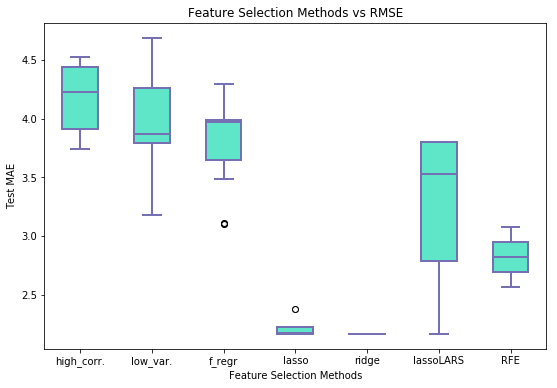
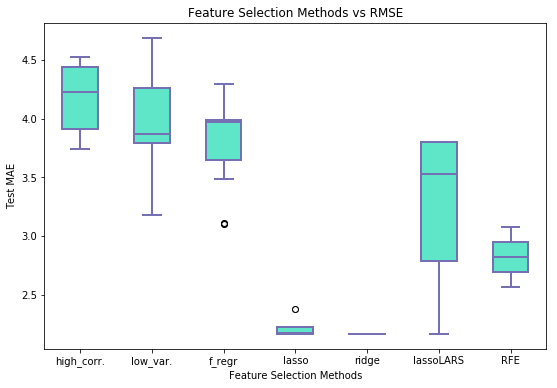
From the above plots we see that regularization methods work well for this dataset and can be a great starting point. However if you have more compute at your disposal, combining this feature selection method with a gradient boosting would give you much higher accuracies. 

Here are some useful links if you would like to learn more -
* [Feature Selection: A survey](http://www.realtechsupport.org/UB/ML+CT/papers/Sahin_FeatureSelectionMethods_2014.pdf)
* [LendingHome Dataset](https://www.kaggle.com/wendykan/lending-club-loan-data) 
* Verta AI:
  * Want to use Verta in your experiments? [Start here](https://verta.readme.io/docs/getting-started)
  * [Why do we need model versioning?](https://medium.com/vertaai/how-to-move-fast-in-ai-without-breaking-things-3ecb74eafd18)